In [1]:
import os
import numpy as np
from tqdm import tqdm

In [2]:
import math

In [3]:
# from scipy.interpolate import BarycentricInterpolator

In [4]:
import matplotlib.pyplot as plt

### initial inspection

In [5]:
fils = os.listdir('dr16qsnr10_npy')

In [6]:
sample = np.load(os.path.join('dr16qsnr10_npy', fils[445]))
sample_2 = np.load(os.path.join('dr16qsnr10_npy', fils[1797]))

In [7]:
sample.shape

(4599, 6)

In [8]:
sample_2.shape

(4595, 6)

In [9]:
sample[:, 0]

array([ 3592.526,  3593.354,  3594.181, ..., 10351.418, 10353.805,
       10356.193])

In [10]:
sample_2[:, 0]

array([ 3606.617,  3607.447,  3608.279, ..., 10382.458, 10384.841,
       10387.236])

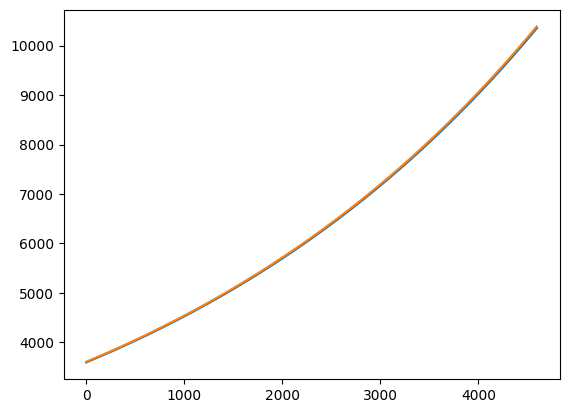

In [11]:
plt.plot(sample[:, 0])
plt.plot(sample_2[:, 0])

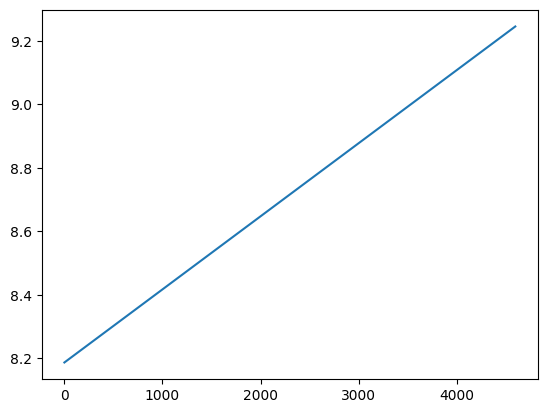

In [12]:
plt.plot(np.log(sample[:, 0]))

seems like the wavelength value are intervaled in log scale

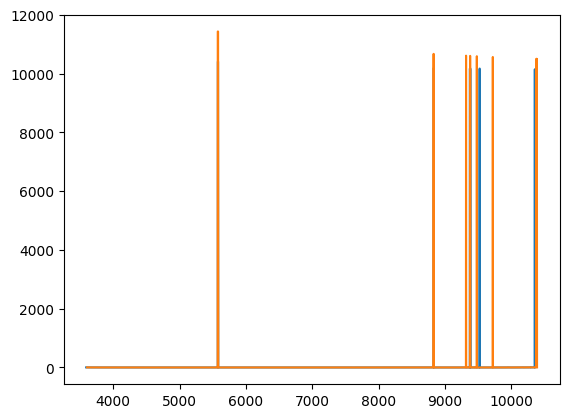

In [13]:
plt.plot(sample[:, 0], sample[:, 2])
plt.plot(sample_2[:, 0], sample_2[:, 2])

### load the entire set

In [14]:
dataset_full = []
for f in tqdm(fils):
    if not f.endswith('.npy'):
        continue
    d = np.load(os.path.join('dr16qsnr10_npy', f))
    dataset_full.append(d)

100%|█████████████████████████████████████████████████████████████████████████| 21787/21787 [04:10<00:00, 86.85it/s]


### perform preprocessing

#### minimun and maximum wavelength value in each spectrum

In [15]:
wavelength_mins = np.array([da[0, 0] for da in dataset_full])
wavelength_maxs = np.array([da[-1, 0] for da in dataset_full])

In [16]:
wavelength_mins

array([3574.374, 3574.374, 3574.374, ..., 3593.354, 3593.354, 3594.181])

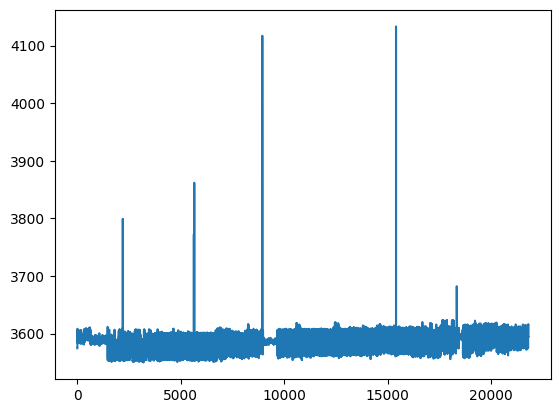

In [17]:
plt.plot(wavelength_mins)

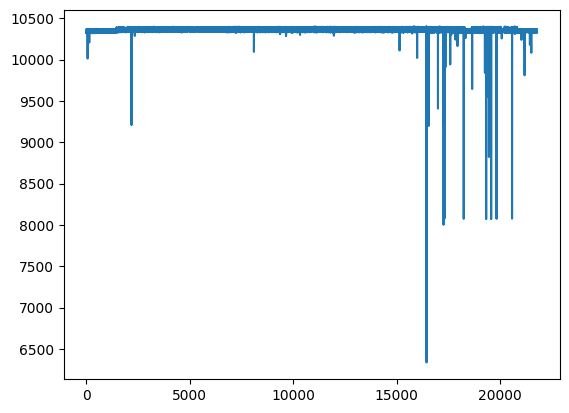

In [18]:
plt.plot(wavelength_maxs)

We now set a minumum and maximum value to chop the spectra off \
then we need to perform interpolation to normalize the spectra all to a same grid

In [19]:
l_min = 3625
l_max = 9000

usable_mask = np.array([1 if ((wavelength_maxs[i] > l_max) and (wavelength_mins[i] < l_min)) else 0 for i in range(len(dataset_full))])

In [20]:
np.sum(usable_mask)

21771

In [21]:
dataset_filtered_usable = [dataset_full[i] for i in range(len(dataset_full)) if usable_mask[i]]

In [22]:
len(dataset_filtered_usable)

21771

In [58]:
# max_vals = [np.max(d[:, 1]) for d in dataset_filtered_usable]
max_vals = []

for d in dataset_filtered_usable:
    wlen = d[:, 0]
    spec = d[:, 1]

    spec_1 = spec[(wlen > l_min - 10) & (wlen < l_max + 10)]

    max_vals.append(np.max(spec_1))

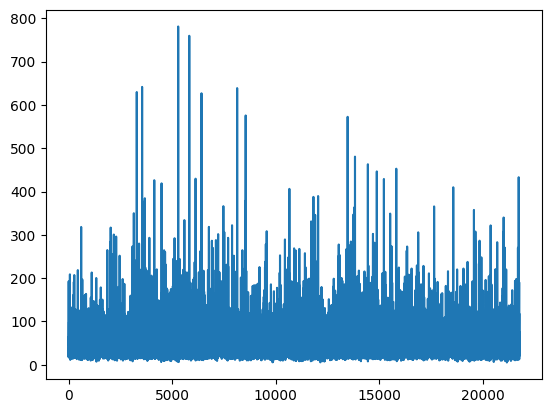

In [59]:
plt.plot(max_vals)

### interpolate

using 4th order spline

In [23]:
# resolution of the unified grid array
# all spectra will become array of size (resolution, )
resolution = 3000

l_min_log = np.log(l_min)
l_max_log = np.log(l_max)
l_range_log = np.linspace(l_min_log, l_max_log, resolution)

In [24]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

In [27]:
# function for interpolating a spectra
# interp_range is the new wavelength grid points
# def interpolate_spectra(l_log, spec, interp_range):
#     spec_new = []
#     for l in interp_range:
#         nearest = find_nearest_idx(l_log,l)
#         # if l < l_log[nearest]: - nvm.
        
#         # 5 points, centered at the nearest coordinate
#         # BarycentricInterpolator(xi, yi)
#         interp = BarycentricInterpolator(l_log[nearest-2:nearest+3], spec[nearest-2:nearest+3])
#         val = interp(l)
#         spec_new.append(val)
#     return spec_new

# interpolates the error term of a spectrum
def interpolate_spectra_errterm(l_log, spec_err, interp_range):
    spec_new = []
    for l in interp_range:
        nearest = find_nearest_idx(l_log,l)
        if l < l_log[nearest]:
            val = max(spec_err[nearest-1], spec_err[nearest])
        else:
            val = max(spec_err[nearest], spec_err[nearest+1])
        spec_new.append(val)
    return spec_new

In [28]:
sample_wlen_log = np.log(dataset_filtered_usable[9][:, 0])
sample_spec = dataset_filtered_usable[9][:, 2]

sample_new_spec = interpolate_spectra_errterm(sample_wlen_log, sample_spec, l_range_log)

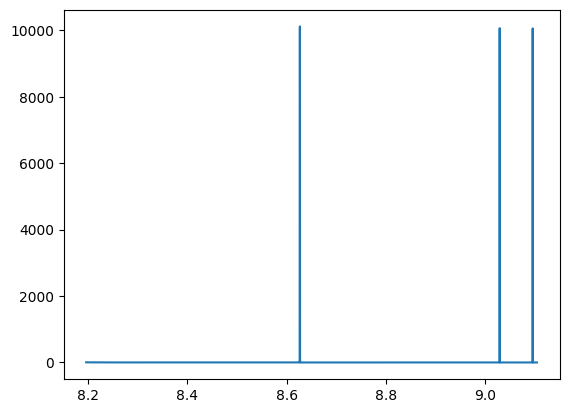

In [29]:
plt.plot(l_range_log, sample_new_spec)

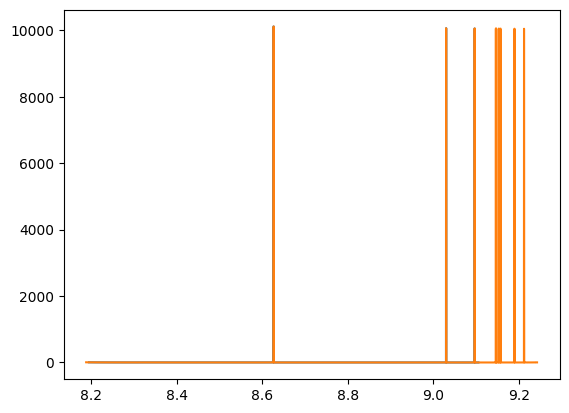

In [30]:
plt.plot(l_range_log, sample_new_spec)
plt.plot(sample_wlen_log, sample_spec)

In [31]:
new_spectra = []

for d in tqdm(dataset_filtered_usable):
    # log of the wavelengths
    # keep the interpolation linear
    wlen_log = np.log(d[:, 0])
    # column index 2 is the error
    spec = d[:, 2]

    # generate new array by using nearst 5 points as interpolation
    spec_new = interpolate_spectra_errterm(wlen_log, spec, l_range_log)
    new_spectra.append(spec_new)

100%|█████████████████████████████████████████████████████████████████████████| 21771/21771 [04:24<00:00, 82.44it/s]


In [32]:
len(new_spectra)

21771

In [33]:
# store the interpolated in this folder
fils_keep = [fils[i] for i in range(len(dataset_full)) if usable_mask[i]]

for i in tqdm(range(len(fils_keep))):
    fil = fils_keep[i]
    dr16_file_outp = open(os.path.join('dr16qsnr10_npy_errterms_interpolated', fil), 'wb')
    np.save(dr16_file_outp, np.array(new_spectra[i]))
    dr16_file_outp.close()

100%|████████████████████████████████████████████████████████████████████████| 21771/21771 [00:28<00:00, 775.94it/s]


In [84]:
new_spectra_np = np.array(new_spectra)

In [86]:
new_spectra_np.shape

(21771, 3000)

In [100]:
# proportion of pixels not in [0, 80] range
np.sum((new_spectra_np > 80) | (new_spectra_np < 0)) / new_spectra_np.size

0.005144488846018404

### scratchpad

In [57]:
a = np.arange(10)
b = a[(a < 7) & (a > 1)]

b

array([2, 3, 4, 5, 6])

In [67]:
ja = np.linspace(-9, 23, 55)

find_nearest_idx(ja,2.4)

19

In [71]:
ja[17:22]

array([1.07407407, 1.66666667, 2.25925926, 2.85185185, 3.44444444])